In [2]:
import os
import numpy as np
import struct
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class MNISTDataset(Dataset):
    def __init__(self, image_file, label_file, transform=None):
        self.images = self._load_images(image_file)
        self.labels = self._load_labels(label_file)
        self.transform = transform

    def _load_images(self, file_path):
        with open(file_path, 'rb') as f:
            magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
            images = np.frombuffer(f.read(), dtype=np.uint8)
            images = images.reshape(num, 1, rows, cols).astype(np.float32) / 255.0  # Normalize to [0, 1]
        return images

    def _load_labels(self, file_path):
        with open(file_path, 'rb') as f:
            magic, num = struct.unpack(">II", f.read(8))
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_images_path = "mnist/train-images.idx3-ubyte"
train_labels_path = "mnist/train-labels.idx1-ubyte"
test_images_path = "mnist/t10k-images.idx3-ubyte"
test_labels_path = "mnist/t10k-labels.idx1-ubyte"

# Create datasets
train_dataset = MNISTDataset(train_images_path, train_labels_path)
test_dataset = MNISTDataset(test_images_path, test_labels_path)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

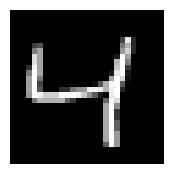

(1, 28, 28)


In [3]:
plt.figure(figsize = (2,2))
plt.axis('off')
plt.imshow(train_dataset[2][0][0],cmap='grey')
plt.show()
print(train_dataset[0][0].shape)

In [4]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Latent space (mean and variance for reparameterization)
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),  # Reshape to 64x7x7
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # 14x14 -> 28x28
            nn.Sigmoid()  # To map the output to [0, 1]
        )
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        z = self.decoder_fc(z)
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

latent_dim = 16  # Suitable for MNIST
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=latent_dim).to(device)


In [5]:
import torch.nn.functional as F

def loss_function(reconstructed_x, x, mu, logvar, lambda_kl=1.0):
    # MSE loss for reconstruction (since MNIST is [0, 1], we use BCE or MSE)
    BCE = F.mse_loss(reconstructed_x, x, reduction='sum')
    
    # KL Divergence loss
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + lambda_kl * KL_divergence

import torch.optim as optim
from tqdm import tqdm

learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(dataloader, model, optimizer, epochs=10, lambda_kl=1.0):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        with tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
            for batch_idx, (data, _) in enumerate(pbar):
                data = data.to(device)
                
                optimizer.zero_grad()
                
                # Forward pass
                reconstructed_x, mu, logvar = model(data)
                
                # Compute the loss
                loss = loss_function(reconstructed_x, data, mu, logvar, lambda_kl)
                
                # Backpropagation
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                # Update progress bar
                pbar.set_postfix(loss=running_loss / (batch_idx + 1))

        avg_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')


In [6]:
### Train Model
lambda_kl = 1
epochs = 50
train(train_loader, model, optimizer, epochs=epochs, lambda_kl=lambda_kl)

Epoch 1/50: 100%|██████████| 938/938 [00:43<00:00, 21.57batch/s, loss=5.22e+3] 


Epoch [1/50], Loss: 81.6303


Epoch 2/50: 100%|██████████| 938/938 [00:04<00:00, 208.02batch/s, loss=2.53e+3]


Epoch [2/50], Loss: 39.5267


Epoch 3/50: 100%|██████████| 938/938 [00:04<00:00, 213.68batch/s, loss=2.27e+3]


Epoch [3/50], Loss: 35.5636


Epoch 4/50: 100%|██████████| 938/938 [00:04<00:00, 204.74batch/s, loss=2.18e+3]


Epoch [4/50], Loss: 34.0150


Epoch 5/50: 100%|██████████| 938/938 [00:04<00:00, 216.75batch/s, loss=2.12e+3]


Epoch [5/50], Loss: 33.1254


Epoch 6/50: 100%|██████████| 938/938 [00:04<00:00, 206.14batch/s, loss=2.08e+3]


Epoch [6/50], Loss: 32.5423


Epoch 7/50: 100%|██████████| 938/938 [00:04<00:00, 222.30batch/s, loss=2.06e+3]


Epoch [7/50], Loss: 32.1418


Epoch 8/50: 100%|██████████| 938/938 [00:04<00:00, 206.49batch/s, loss=2.04e+3]


Epoch [8/50], Loss: 31.8216


Epoch 9/50: 100%|██████████| 938/938 [00:04<00:00, 227.03batch/s, loss=2.02e+3]


Epoch [9/50], Loss: 31.5171


Epoch 10/50: 100%|██████████| 938/938 [00:04<00:00, 217.53batch/s, loss=2e+3]   


Epoch [10/50], Loss: 31.3401


Epoch 11/50: 100%|██████████| 938/938 [00:04<00:00, 215.59batch/s, loss=1.99e+3]


Epoch [11/50], Loss: 31.1195


Epoch 12/50: 100%|██████████| 938/938 [00:04<00:00, 214.44batch/s, loss=1.98e+3]


Epoch [12/50], Loss: 30.9391


Epoch 13/50: 100%|██████████| 938/938 [00:04<00:00, 208.83batch/s, loss=1.97e+3]


Epoch [13/50], Loss: 30.7967


Epoch 14/50: 100%|██████████| 938/938 [00:04<00:00, 223.15batch/s, loss=1.96e+3]


Epoch [14/50], Loss: 30.6673


Epoch 15/50: 100%|██████████| 938/938 [00:04<00:00, 211.01batch/s, loss=1.95e+3]


Epoch [15/50], Loss: 30.5543


Epoch 16/50: 100%|██████████| 938/938 [00:04<00:00, 217.37batch/s, loss=1.95e+3]


Epoch [16/50], Loss: 30.4341


Epoch 17/50: 100%|██████████| 938/938 [00:04<00:00, 217.25batch/s, loss=1.94e+3]


Epoch [17/50], Loss: 30.3540


Epoch 18/50: 100%|██████████| 938/938 [00:04<00:00, 203.88batch/s, loss=1.93e+3]


Epoch [18/50], Loss: 30.2409


Epoch 19/50: 100%|██████████| 938/938 [00:04<00:00, 218.16batch/s, loss=1.93e+3]


Epoch [19/50], Loss: 30.1619


Epoch 20/50: 100%|██████████| 938/938 [00:04<00:00, 218.14batch/s, loss=1.92e+3]


Epoch [20/50], Loss: 30.0888


Epoch 21/50: 100%|██████████| 938/938 [00:04<00:00, 207.77batch/s, loss=1.92e+3]


Epoch [21/50], Loss: 30.0641


Epoch 22/50: 100%|██████████| 938/938 [00:04<00:00, 215.77batch/s, loss=1.91e+3]


Epoch [22/50], Loss: 29.9228


Epoch 23/50: 100%|██████████| 938/938 [00:04<00:00, 227.38batch/s, loss=1.91e+3]


Epoch [23/50], Loss: 29.9150


Epoch 24/50: 100%|██████████| 938/938 [00:04<00:00, 206.87batch/s, loss=1.91e+3]


Epoch [24/50], Loss: 29.8083


Epoch 25/50: 100%|██████████| 938/938 [00:04<00:00, 214.54batch/s, loss=1.9e+3] 


Epoch [25/50], Loss: 29.7744


Epoch 26/50: 100%|██████████| 938/938 [00:04<00:00, 205.59batch/s, loss=1.9e+3]


Epoch [26/50], Loss: 29.7037


Epoch 27/50: 100%|██████████| 938/938 [00:04<00:00, 218.96batch/s, loss=1.9e+3] 


Epoch [27/50], Loss: 29.6475


Epoch 28/50: 100%|██████████| 938/938 [00:04<00:00, 206.60batch/s, loss=1.89e+3]


Epoch [28/50], Loss: 29.5952


Epoch 29/50: 100%|██████████| 938/938 [00:04<00:00, 219.39batch/s, loss=1.89e+3]


Epoch [29/50], Loss: 29.5308


Epoch 30/50: 100%|██████████| 938/938 [00:04<00:00, 216.91batch/s, loss=1.89e+3]


Epoch [30/50], Loss: 29.5183


Epoch 31/50: 100%|██████████| 938/938 [00:04<00:00, 204.71batch/s, loss=1.88e+3]


Epoch [31/50], Loss: 29.4538


Epoch 32/50: 100%|██████████| 938/938 [00:04<00:00, 203.83batch/s, loss=1.88e+3]


Epoch [32/50], Loss: 29.4077


Epoch 33/50: 100%|██████████| 938/938 [00:04<00:00, 221.48batch/s, loss=1.88e+3]


Epoch [33/50], Loss: 29.3548


Epoch 34/50: 100%|██████████| 938/938 [00:04<00:00, 217.20batch/s, loss=1.87e+3]


Epoch [34/50], Loss: 29.3046


Epoch 35/50: 100%|██████████| 938/938 [00:04<00:00, 213.25batch/s, loss=1.87e+3]


Epoch [35/50], Loss: 29.2884


Epoch 36/50: 100%|██████████| 938/938 [00:04<00:00, 217.91batch/s, loss=1.87e+3]


Epoch [36/50], Loss: 29.2433


Epoch 37/50: 100%|██████████| 938/938 [00:04<00:00, 218.62batch/s, loss=1.87e+3]


Epoch [37/50], Loss: 29.2060


Epoch 38/50: 100%|██████████| 938/938 [00:04<00:00, 205.37batch/s, loss=1.87e+3]


Epoch [38/50], Loss: 29.1592


Epoch 39/50: 100%|██████████| 938/938 [00:04<00:00, 207.14batch/s, loss=1.86e+3]


Epoch [39/50], Loss: 29.1364


Epoch 40/50: 100%|██████████| 938/938 [00:04<00:00, 201.22batch/s, loss=1.86e+3]


Epoch [40/50], Loss: 29.0996


Epoch 41/50: 100%|██████████| 938/938 [00:04<00:00, 211.36batch/s, loss=1.86e+3]


Epoch [41/50], Loss: 29.0599


Epoch 42/50: 100%|██████████| 938/938 [00:04<00:00, 217.77batch/s, loss=1.86e+3]


Epoch [42/50], Loss: 29.0076


Epoch 43/50: 100%|██████████| 938/938 [00:04<00:00, 201.42batch/s, loss=1.85e+3]


Epoch [43/50], Loss: 28.9935


Epoch 44/50: 100%|██████████| 938/938 [00:04<00:00, 222.36batch/s, loss=1.85e+3]


Epoch [44/50], Loss: 28.9617


Epoch 45/50: 100%|██████████| 938/938 [00:04<00:00, 229.00batch/s, loss=1.85e+3]


Epoch [45/50], Loss: 28.9349


Epoch 46/50: 100%|██████████| 938/938 [00:04<00:00, 217.08batch/s, loss=1.85e+3]


Epoch [46/50], Loss: 28.8879


Epoch 47/50: 100%|██████████| 938/938 [00:04<00:00, 203.63batch/s, loss=1.85e+3]


Epoch [47/50], Loss: 28.8628


Epoch 48/50: 100%|██████████| 938/938 [00:04<00:00, 214.68batch/s, loss=1.84e+3]


Epoch [48/50], Loss: 28.8138


Epoch 49/50: 100%|██████████| 938/938 [00:04<00:00, 211.06batch/s, loss=1.84e+3]


Epoch [49/50], Loss: 28.7920


Epoch 50/50: 100%|██████████| 938/938 [00:04<00:00, 210.68batch/s, loss=1.84e+3]

Epoch [50/50], Loss: 28.7588


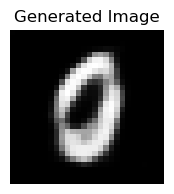

In [43]:
model.eval()

with torch.no_grad():
    # Sample a random latent vector (from a standard normal distribution)
    random_latent = torch.randn(1, latent_dim).to(device)
    generated_image = model.decode(random_latent)
    generated_image = generated_image.cpu().squeeze(0).detach().numpy()
    generated_image = generated_image.transpose(1, 2, 0)
    
plt.figure(figsize=(2, 2))
plt.imshow(generated_image, cmap='grey')
plt.title("Generated Image")
plt.axis('off')
plt.savefig(f"out/leminst{latent_dim}-9543235.png")
plt.show()

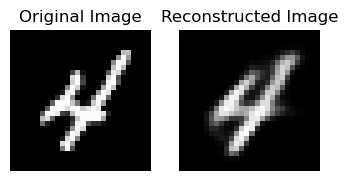

In [44]:
import torch
import matplotlib.pyplot as plt

# Get the image and label
i = 9
image_tensor = train_dataset[i][0]

# Convert numpy array to PyTorch tensor (if it's not already)
image_tensor = torch.tensor(image_tensor).float()

# Add batch dimension and move to the device (e.g., CUDA)
img = image_tensor.unsqueeze(0).to(device)

# Forward pass through the model
with torch.no_grad():
    mu, logvar = model.encode(img)
    latent_rep = model.reparameterize(mu, logvar)
    reconstructed_image = model.decode(latent_rep)
    
    # Since the output is from a sigmoid, it should already be in [0, 1] range
    reconstructed_image = reconstructed_image.cpu().squeeze(0).detach().numpy()
    reconstructed_image = reconstructed_image.transpose(1, 2, 0)

# Convert the original image from [0, 1] range and from CxHxW to HxWxC for visualization
image = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert from (C, H, W) to (H, W, C)

# Plot the original and reconstructed images
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(image,cmap='grey')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image,cmap='grey')
plt.title('Reconstructed Image')
plt.axis('off')
plt.savefig(f"out/lrec{latent_dim}-9543235.png")
plt.show()


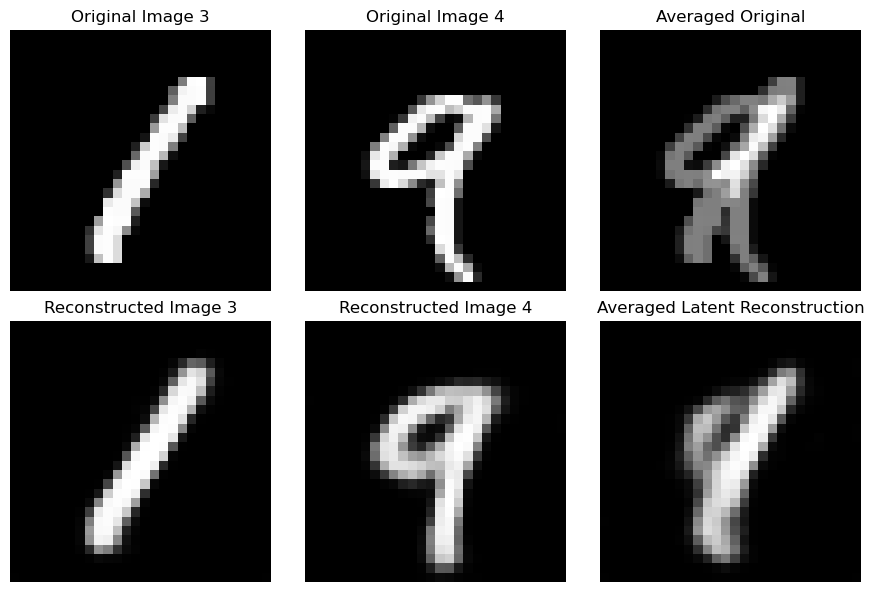

In [45]:
import matplotlib.pyplot as plt

i, j = 3, 4

image_tensor_i = train_dataset[i][0]
image_tensor_j = train_dataset[j][0]

# Convert to tensors and move to device
img_i = torch.tensor(image_tensor_i).unsqueeze(0).to(device).float()
img_j = torch.tensor(image_tensor_j).unsqueeze(0).to(device).float()

# Forward pass through the encoder to get latents
with torch.no_grad():
    mu_i, logvar_i = model.encode(img_i)
    mu_j, logvar_j = model.encode(img_j)

    latent_rep_i = model.reparameterize(mu_i, logvar_i)
    latent_rep_j = model.reparameterize(mu_j, logvar_j)

    reconstructed_image_i = model.decode(latent_rep_i).cpu().squeeze(0).detach().numpy()
    reconstructed_image_j = model.decode(latent_rep_j).cpu().squeeze(0).detach().numpy()

    # Average the latent representations
    averaged_latent = (latent_rep_i + latent_rep_j) / 2
    reconstructed_image_avg = model.decode(averaged_latent).cpu().squeeze(0).detach().numpy()

    # Convert images to proper format (C, H, W to H, W, C)
    image_i = image_tensor_i.transpose(1, 2, 0)
    image_j = image_tensor_j.transpose(1, 2, 0)

    reconstructed_image_i = reconstructed_image_i.transpose(1, 2, 0)
    reconstructed_image_j = reconstructed_image_j.transpose(1, 2, 0)
    reconstructed_image_avg = reconstructed_image_avg.transpose(1, 2, 0)

plt.figure(figsize=(9, 6))

# Original images
plt.subplot(2, 3, 1)
plt.imshow(image_i, cmap='gray')  # Set cmap to 'gray'
plt.title(f'Original Image {i}')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(image_j, cmap='gray')  # Set cmap to 'gray'
plt.title(f'Original Image {j}')
plt.axis('off')

# Averaged original images
plt.subplot(2, 3, 3)
plt.imshow((image_i + image_j) / 2, cmap='gray')  # Set cmap to 'gray'
plt.title(f'Averaged Original')
plt.axis('off')

# Reconstructed images
plt.subplot(2, 3, 4)
plt.imshow(reconstructed_image_i, cmap='gray')  # Set cmap to 'gray'
plt.title(f'Reconstructed Image {i}')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(reconstructed_image_j, cmap='gray')  # Set cmap to 'gray'
plt.title(f'Reconstructed Image {j}')
plt.axis('off')

# Reconstructed from averaged latent space
plt.subplot(2, 3, 6)
plt.imshow(reconstructed_image_avg, cmap='gray')  # Set cmap to 'gray'
plt.title(f'Averaged Latent Reconstruction')
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()



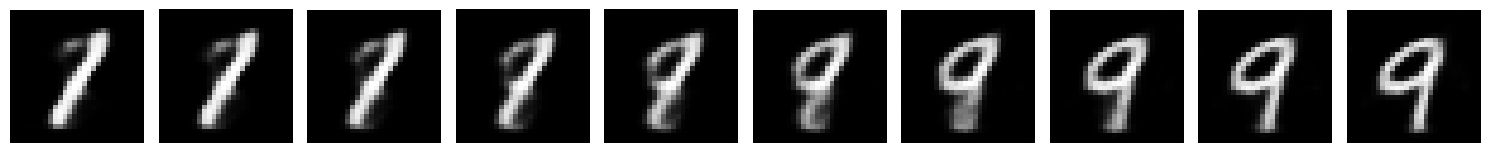

In [46]:
with torch.no_grad():
    mu_i, logvar_i = model.encode(img_i)
    mu_j, logvar_j = model.encode(img_j)

    latent_rep_i = model.reparameterize(mu_i, logvar_i)
    latent_rep_j = model.reparameterize(mu_j, logvar_j)

    # Generate 10 weighted averages of latent representations
    weights = np.linspace(0, 1, 10)
    interpolated_latents = [
        (1 - w) * latent_rep_i + w * latent_rep_j for w in weights
    ]
    reconstructed_images = [
        model.decode(latent).cpu().squeeze(0).detach().numpy() for latent in interpolated_latents
    ]

    # Convert reconstructed images to proper format (C, H, W to H, W, C)
    reconstructed_images = [
        img.transpose(1, 2, 0) for img in reconstructed_images
    ]

# Visualization
plt.figure(figsize=(15, 3))  # Linear layout

# Plot interpolated images
for idx, img in enumerate(reconstructed_images):
    plt.subplot(1, len(reconstructed_images), idx + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Save and display the plot
plt.tight_layout()
plt.savefig('interpolated_images4.png')
plt.show()
